In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')
import reboundx
from multiprocessing import Pool   
from celmech.disturbing_function import get_fg_coeffs
from celmech import Andoyer, Poincare
from celmech.resonances import resonant_period_ratios, resonance_pratio_span
from celmech.nbody_simulation_utilities import set_timestep,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.nbody_simulation_utilities import reb_add_from_elements
from celmech import Poincare
import rebound as rb
from celmech.secular import LaplaceLagrangeSystem
from subprocess import call

In [2]:
def sec(sim, i1, i2):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    pvars = Poincare.from_Simulation(sim)
    res['Lambda'] = np.array([p.Lambda for p in pvars.particles[1:]])
    res['Gamma'] = np.array([p.Gamma for p in pvars.particles[1:]])
    res['L10'] = res['Lambda'][i1-1]
    res['L20'] = res['Lambda'][i2-1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
    res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([p.gamma for p in pvars.particles[1:]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([p.gamma for p in pvars.particles[1:]])
    res['M'] = lsys.Neccentricity_matrix # no longer normalized
    res['S'] = np.identity(res['Lambda'].shape[0])*np.sqrt(res['Lr']) # Nplanets x Nplanets rotation matrix
    for i, L in enumerate(res['Lambda']):
        res['S'][i,i] /= np.sqrt(L)
    eigvals= lsys.eccentricity_eigenvalues()
    res['Tsec'] = np.abs(2 * np.pi / eigvals)
    return res

def eq_mass_eigen(seed, P12, P3, etilde, mu):
    np.random.seed(seed)
    ec = 1 - P12**(2/3)
    e = etilde*ec

    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12, 'M':np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':P3}, sim=sim)
    sim.move_to_com()

    secsim = sec(sim, 1, 2)
    Mprime = secsim['M']
    vals,T = np.linalg.eigh(Mprime)
    freqs = np.diag(np.diag(vals))
    
    # initialize in first eigenmode
    A = [1,0,0]
    v0 = T @ A
    v0 /= np.linalg.norm(v0)
    
    zstar = secsim['S'] @ v0
    zstar = zstar/(zstar[1]-zstar[0]) # normalize so em12 = 1
    
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1,'e':abs(zstar[0])*e, 'pomega':np.arccos(np.sign(zstar[0])), 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12,'e':abs(zstar[1])*e, 'pomega':np.arccos(np.sign(zstar[1])), 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':P3,'e':abs(zstar[2])*e, 'pomega':np.arccos(np.sign(zstar[2])), 'M':np.random.random()*2*np.pi}, sim=sim)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.collision="direct"
    ps = sim.particles
    minTperi = ps[1].P*(1-ps[1].e)**1.5/(1+ps[1].e)**0.5
    sim.dt = minTperi/20
    
    for p in ps[1:]:
        p.r = p.a*(p.m/3)**(1/3)
        
    return sim

def megno_eqmass_eigen(params): # collision: megno = 10000, lyap = 1/10, megno nan: megno = 1000, lyap = 1/20
    seed, P12, P3, etilde, mu, tmax = params
    sim = eq_mass_eigen(seed, P12, P3, etilde, mu)
    if tmax is None:
        lsys = LaplaceLagrangeSystem.from_Simulation(sim)
        eigvals = lsys.eccentricity_eigenvalues()
        Tsec = np.abs(2 * np.pi / eigvals)
        tmax = 3*Tsec[1] # take the middle eigenvalue, rather than the much larger longest one coming from approx ecom cons.
    sim.init_megno()
    try:
        sim.integrate(tmax)
    except:
        megno = 1000
        return megno
    megno = sim.calculate_megno()
    if np.isnan(megno):
        megno = 1000
    return megno

In [3]:
def get_pool_params(xlist, ylist, P3, mu=1e-4, tmax=None):
    params = []
    ctr = 0
    for y in ylist:
        for x in xlist:
            params.append((ctr, x, P3, y, mu, tmax))
            ctr += 1
    return params
             
def get_centered_grid(xlist, ylist, poolresults):  
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(poolresults).reshape(len(ylist),len(xlist))

    return X,Y,Z

def relativelyprime(num1, num2):
    mn = min(num1, num2) 
    for i in range(1, mn+1): 
         if num1%i==0 and num2%i==0: 
             hcf = i 
    if hcf == 1: 
         return True
    else: 
         return False
        
def LLsoln(M, Gx0, Gy0, times):
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    freqs = np.diag(np.diag(vals))
    Ax0 = T.T @ Gx0
    Ay0 = T.T @ Gy0
    print(Ax0)
    print(Ay0)
    
    cos_vals = np.array([np.cos(freq * times) for freq in freqs]).T
    sin_vals = np.array([np.sin( freq * times) for freq in freqs]).T
    Ax = Ax0 * cos_vals - Ay0 * sin_vals    
    Ay = Ax0 * sin_vals + Ay0 * cos_vals
    Gx = np.transpose(T @ Ax.T).T
    Gy = np.transpose(T @ Ay.T).T
    
    return Gx, Gy

def LLeminus(sim, times, i1, i2):
    secres = sec(sim, i1, i2)
    Gx, Gy = LLsoln(secres['M'], secres['Gammax'], secres['Gammay'], times)
    Fx = secres['R'] @ Gx/secres['Lr']**(1/2)
    Fy = secres['R'] @ Gy/secres['Lr']**(1/2)
    eminus = np.sqrt(Fx[i1-1]**2 + Fy[i1-1]**2) # eminus is always in the i1 slot
    return eminus

In [5]:
mu=1e-4
etildemax=0.8
P3 = 2.0328
tmax = None

Pmin = 2/3
Pmax = 3/4
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [5]:
%%time
params = get_pool_params(P12s, etildes, P3=P3, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(megno_eqmass_eigen, params)
np.save('multipleMMRsEigenMode_close.npy', results)

CPU times: user 27.5 s, sys: 16.4 s, total: 43.9 s
Wall time: 4h 56min 33s


In [6]:
mu=1e-4
etildemax=0.8
P3 = 3.03
tmax = None

Pmin = 1/2
Pmax = 2/3
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

In [ ]:
%%time
params = get_pool_params(P12s, etildes, P3=P3, mu=mu, tmax=tmax)
pool = Pool()
results = pool.map(megno_eqmass_eigen, params)
np.save('multipleMMRsEigenMode_wide.npy', results)

Calculate the appropriate values of e23tilde, which vary over the grid

In [8]:
%%time

mu=1e-4
etildemax=0.8
P3 = 2.0328

Pmin = 2/3
Pmax = 3/4
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

etilde23overetilde12sclose = []
for P12 in P12s:
    sim = eq_mass_eigen(0, P12, P3, 0.2, mu) # ratio of e23/e12 only changes by about 1% for different etilde
    P23 = 1/P12/P3
    ps = sim.particles
    e12x = ps[2].e*np.cos(ps[2].pomega) - ps[1].e*np.cos(ps[1].pomega)
    e12y = ps[2].e*np.sin(ps[2].pomega) - ps[1].e*np.sin(ps[1].pomega)
    e12 = np.sqrt(e12x**2 + e12y**2)
    e23x = ps[3].e*np.cos(ps[3].pomega) - ps[2].e*np.cos(ps[2].pomega)
    e23y = ps[3].e*np.sin(ps[3].pomega) - ps[2].e*np.sin(ps[2].pomega)
    e23 = np.sqrt(e23x**2 + e23y**2)
    e12c = (1-P12**(2/3))
    e23c = (1-P23**(2/3))
    etilde12 = e12/e12c
    etilde23 = e23/e23c
    etilde23overetilde12sclose.append(etilde23/etilde12)
np.save('eratio_close.npy', np.array(etilde23overetilde12sclose))

CPU times: user 1min 52s, sys: 6.04 s, total: 1min 58s
Wall time: 1min 50s


In [9]:
%%time

mu=1e-4
etildemax=0.8
P3 = 3.03
tmax = 2e4

Pmin = 1/2
Pmax = 2/3
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

etilde23overetilde12swide = []
for P12 in P12s:
    sim = eq_mass_eigen(0, P12, P3, 0.2, mu) # ratio of e23/e12 only changes by about 1% for different etilde
    P23 = 1/P12/P3
    ps = sim.particles
    e12x = ps[2].e*np.cos(ps[2].pomega) - ps[1].e*np.cos(ps[1].pomega)
    e12y = ps[2].e*np.sin(ps[2].pomega) - ps[1].e*np.sin(ps[1].pomega)
    e12 = np.sqrt(e12x**2 + e12y**2)
    e23x = ps[3].e*np.cos(ps[3].pomega) - ps[2].e*np.cos(ps[2].pomega)
    e23y = ps[3].e*np.sin(ps[3].pomega) - ps[2].e*np.sin(ps[2].pomega)
    e23 = np.sqrt(e23x**2 + e23y**2)
    e12c = (1-P12**(2/3))
    e23c = (1-P23**(2/3))
    etilde12 = e12/e12c
    etilde23 = e23/e23c
    etilde23overetilde12swide.append(etilde23/etilde12)
np.save('eratio_wide.npy', np.array(etilde23overetilde12swide))

CPU times: user 1min 53s, sys: 2.39 s, total: 1min 56s
Wall time: 1min 53s


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in log


[1.333  1.3664 1.3998 1.4332 1.4666 1.5   ]


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: divide by zero encountered in log


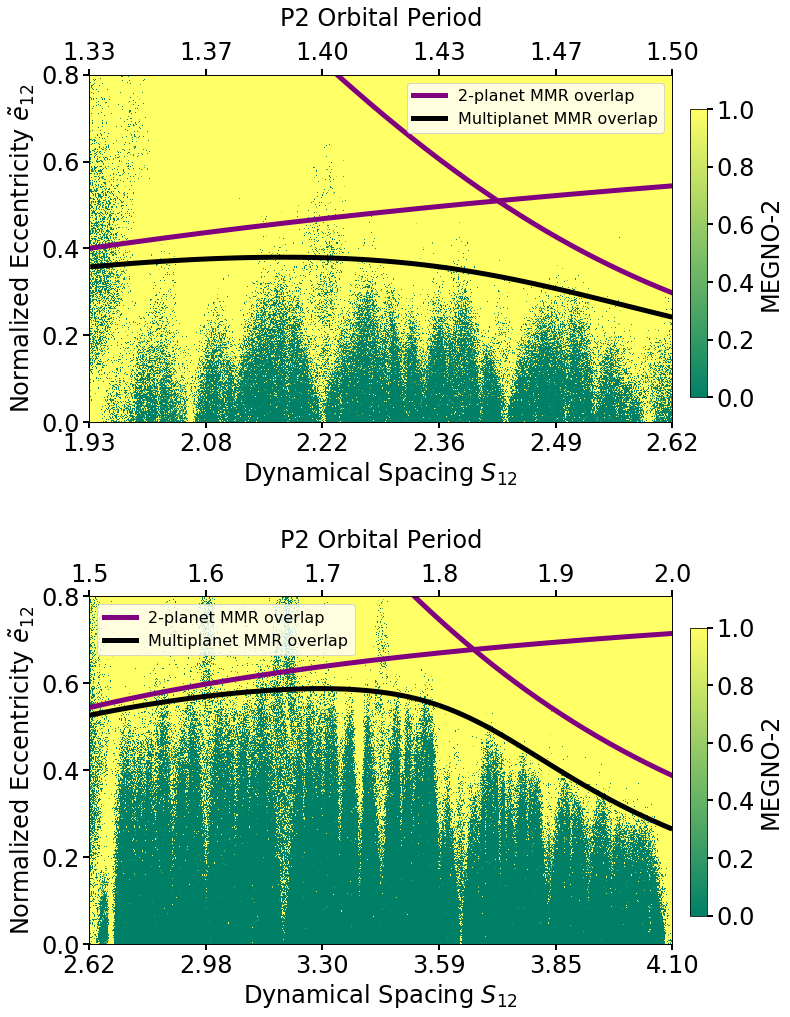

In [4]:
from matplotlib.lines import Line2D
plt.style.use('paper')

fig, axarr = plt.subplots(figsize=(12,16), nrows=2)

ax = axarr[0]

mu=1e-4
etildemax=0.8
P3 = 2.0328
tmax = 2e4

Pmin = 2/3
Pmax = 3/4
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

megno = np.load('multipleMMRsEigenMode_close.npy')
etilde23overetilde12sclose = np.load('eratio_close.npy')

X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)
ax.set_xlabel(r"$P2/P1$")

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='purple', lw=5)

P23s = 1/P12s/P3
m12 = 2*mu/3
m23 = 2*mu/3

deltas23 = (1-P23s**(2/3))/m23**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas23**(-4/3))/np.array(etilde23overetilde12sclose), color='purple', lw=5)

P12sgrid, etildes12grid = np.meshgrid(P12s, etildes)
P23sgrid, _ = np.meshgrid(P23s, etildes)
etilde23overetilde12sgrid, _ = np.meshgrid(etilde23overetilde12sclose, etildes)
etildes23grid = etildes12grid*etilde23overetilde12sgrid 

deltas12grid = (1-P12sgrid**(2/3))/(m12)**(1/4)
deltas23grid = (1-P23sgrid**(2/3))/(m23)**(1/4)
tau12low = etildes12grid * (2.9/deltas12grid)**2
tau23low = etildes23grid * (2.9/deltas23grid)**2
tau12H18 = 1.15/deltas12grid**2/np.abs(np.log(etildes12grid**0.5))**(3/2)
tau23H18 = 1.15/deltas23grid**2/np.abs(np.log(etildes23grid**0.5))**(3/2)
taulow = tau12low + tau23low
tauH18 = tau12H18 + tau23H18

cs = ax.contour(1/P12sgrid, etildes12grid, tauH18, levels=[1], colors='k', linewidths=[5])

custom_lines = [Line2D([0], [0], color='purple', lw=5), Line2D([0], [0], color='black', lw=5)]
ax.legend(custom_lines, ['2-planet MMR overlap', 'Multiplanet MMR overlap'])


ax.set_xlim([1/P12s.max(), 1/P12s.min()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_ylabel(r'$e_{12}/e_{\rm{cross}}$', fontsize=24)


cbar_ax = fig.add_axes([0.82, 0.6, 0.02, 0.25])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)

cb.ax.tick_params(labelsize=24)

ax.set_xticks(np.linspace(1.333, 1.5, 6))
ax.set_xticklabels(["{0:.2f}".format(d) for d in ax.get_xticks()])

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel("P2 Orbital Period", fontsize=24, labelpad=15)
ax.set_ylabel(r'Normalized Eccentricity $\tilde{e}_{\rm{12}}}$')
ax2 = ax.twiny()
ax2.set_xticklabels(["{0:.2f}".format(d) for d in [(1-P21**(-2/3))/(2*mu/3)**(1/4) for P21 in ax.get_xticks()]], fontsize=24)
ax2.set_xlabel(r'Dynamical Spacing $S_{12}$', fontsize=24)
ax2.xaxis.tick_bottom()
ax2.xaxis.set_label_position('bottom')
#ax2.tick_params(axis='both', which='major', labelsize=18)
print(ax.get_xticks())
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax = axarr[1]

mu=1e-4
etildemax=0.8
P3 = 3.03
tmax = 2e4

Pmin = 1/2
Pmax = 2/3
NPs = 960
Nes = 320
P12s = np.linspace(Pmin, Pmax, NPs)
etildes = np.linspace(0, etildemax, Nes)

megno = np.load('multipleMMRsEigenMode_wide.npy')
etilde23overetilde12swide = np.load('eratio_wide.npy')

X,Y,Z = get_centered_grid(1/P12s, etildes, np.array(megno)-2)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="summer", rasterized=True)

deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='purple', lw=5)

P23s = 1/P12s/P3
m12 = 2*mu/3
m23 = 2*mu/3

deltas23 = (1-P23s**(2/3))/m23**(1/4)
ax.plot(1/P12s, np.exp(-2.2*deltas23**(-4/3))/np.array(etilde23overetilde12sclose), color='purple', lw=5)


P12sgrid, etildes12grid = np.meshgrid(P12s, etildes)
P23sgrid, _ = np.meshgrid(P23s, etildes)
etilde23overetilde12sgrid, _ = np.meshgrid(etilde23overetilde12swide, etildes)
etildes23grid = etildes12grid*etilde23overetilde12sgrid 

deltas12grid = (1-P12sgrid**(2/3))/(m12)**(1/4)
deltas23grid = (1-P23sgrid**(2/3))/(m23)**(1/4)
tau12low = etildes12grid * (2.9/deltas12grid)**2
tau23low = etildes23grid * (2.9/deltas23grid)**2
tau12H18 = 1.15/deltas12grid**2/np.abs(np.log(etildes12grid**0.5))**(3/2)
tau23H18 = 1.15/deltas23grid**2/np.abs(np.log(etildes23grid**0.5))**(3/2)
taulow = tau12low + tau23low
tauH18 = tau12H18 + tau23H18

cs = ax.contour(1/P12sgrid, etildes12grid, tauH18, levels=[1], colors='k', linewidths=[5])

custom_lines = [Line2D([0], [0], color='purple', lw=5), Line2D([0], [0], color='black', lw=5)]
ax.legend(custom_lines, ['2-planet MMR overlap', 'Multiplanet MMR overlap'])

ax.set_xlim([1/P12s.max(), 1/P12s.min()])
ax.set_ylim([etildes.min(), etildes.max()])
ax.set_ylabel(r'$e_{12}/e_{\rm{cross}}$', fontsize=24)


fig.subplots_adjust(right=0.8, wspace=0.05, hspace=0.5)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.25])

#cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.3])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("MEGNO-2", fontsize=24)

cb.ax.tick_params(labelsize=24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel("P2 Orbital Period", fontsize=24, labelpad=15)
ax.set_ylabel(r'Normalized Eccentricity $\tilde{e}_{\rm{12}}}$')
ax2 = ax.twiny()
ax2.set_xticklabels(["{0:.2f}".format(d) for d in [(1-P21**(-2/3))/(2*mu/3)**(1/4) for P21 in ax.get_xticks()]], fontsize=24)
ax2.set_xlabel(r'Dynamical Spacing $S_{12}$', fontsize=24)
ax2.xaxis.tick_bottom()
ax2.xaxis.set_label_position('bottom')
#ax2.tick_params(axis='both', which='major', labelsize=18)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.savefig('multipleMMRs.pdf')